# Isolation Forest

## Import Data

In [1]:
import pandas as pd

train_df = pd.read_csv("../data/processed_train_df.csv")
print(train_df.shape)

test_df = pd.read_csv("../data/processed_test_df.csv")
print(test_df.shape)

df = pd.concat([train_df, test_df])
print(df.shape)

(227845, 31)
(56962, 31)
(284807, 31)


In [2]:
# Exclude labels

y_train = train_df['Class']
X_train = train_df.copy().drop('Class', axis=1)

X_train.columns

y_test = test_df['Class']
X_test = test_df.copy().drop('Class', axis=1)

labels = df['Class']
df_unlabelled = df.copy().drop('Class', axis=1)

## Model Building

In [3]:
from sklearn.ensemble import IsolationForest

# Initialise model
iso = IsolationForest(
    n_estimators=300,
    max_samples="auto",
    contamination=0.0015,  # expected proportion of anomalies; tune later
    random_state=42,
    n_jobs=-1
)

# Fit on training data (unsupervised: no y_train used)
iso.fit(X_train)

IsolationForest(contamination=0.0015, n_estimators=300, n_jobs=-1,
                random_state=42)

In [4]:
# Raw anomaly scores (lower = more anomalous)
raw_scores = iso.score_samples(X_train)

# Flip sign so higher = more anomalous
anomaly_scores = -raw_scores

# Binary predictions (-1 = anomaly, 1 = normal) → convert to 0/1
pred_labels = (iso.predict(X_train) == -1).astype(int)

# Put into a DataFrame for inspection
results = pd.DataFrame({
    "anomaly_score": anomaly_scores,
    "predicted_label": pred_labels,
    "true_label": y_train  # only for later evaluation
}, index=X_train.index)

results.head()

,anomaly_score,predicted_label,true_label
0,0.404523,0,0
1,0.399473,0,0
2,0.498132,0,0
3,0.383167,0,0
4,0.408922,0,0


In [5]:
import numpy as np

cutoff = np.quantile(anomaly_scores, 0.985)
print(cutoff.round(4))

0.5574


ROC AUC: 0.9455
PR AUC: 0.1306


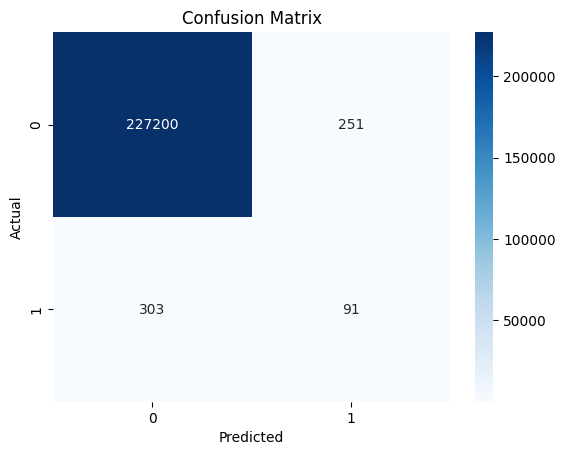

In [6]:
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

roc = roc_auc_score(y_train, anomaly_scores)
pr_auc = average_precision_score(y_train, anomaly_scores)
cm = confusion_matrix(y_train, pred_labels)

print(f"ROC AUC: {roc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

# Confusion Matrix
sns.heatmap(confusion_matrix(y_train, pred_labels), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

So, we can see that this model does not perform particularly well, especially when compared to the 0.76 PR AUC of our quick Logistic Regression model from EDA. Let's try tuning it.

## Hyperparameter Tuning

In [7]:
def precision_recall_at_k(y_true, scores, k=0.01):
    """
    Compute Precision@k and Recall@k for anomaly scores.
    y_true: array-like of shape (n,) with 0/1 labels
    scores: array-like of shape (n,) with higher = more anomalous
    k: fraction of samples to flag (e.g. 0.01 = top 1%)
    """
    n = len(scores)
    top_n = max(1, int(np.ceil(k * n)))  # at least one sample

    # Get indices of top-k scores
    idx = np.argsort(-scores)[:top_n]

    # Precision = frauds / flagged
    precision = y_true.iloc[idx].mean()

    # Recall = frauds caught / total frauds
    recall = y_true.iloc[idx].sum() / y_true.sum()

    return precision, recall

In [12]:
from sklearn.model_selection import ParameterGrid

PRIMARY = "pr_auc"
SECONDARY = "p_at_1"

# Note that I have already narrowed the param_grid down through multiple iterations

param_grid = {
    "n_estimators": [400, 500, 600],
    "max_samples": [3072, 4096, 5120],
    "bootstrap": [False, True],
    # Note: intentionally not tuning 'contamination' here
}

runs = []
best_tuple = (-np.inf, -np.inf)  # (primary, secondary)
best_params = None
best_model = None
best_scores = None

for params in ParameterGrid(param_grid):
    iso = IsolationForest(max_features=1, random_state=42, n_jobs=-1, **params) # Used param_grid to work out max_features = 1 is optimal
    iso.fit(X_train)

    scores = -iso.score_samples(X_test)

    roc = roc_auc_score(y_test, scores)
    pr_auc = average_precision_score(y_test, scores)
    p_at_1, r_at_1 = precision_recall_at_k(y_test, scores, k=0.01)
    p_at_05, r_at_05 = precision_recall_at_k(y_test, scores, k=0.005)

    runs.append({**params, "ROC": roc, "pr_auc": pr_auc, "p_at_1": p_at_1, "r_at_1": r_at_1, "p_at_05": p_at_05, "r_at_05": r_at_05})

    primary_val = pr_auc if PRIMARY == "pr_auc" else p_at_1
    secondary_val = p_at_1 if SECONDARY == "p_at_1" else pr_auc
    cand_tuple = (primary_val, secondary_val)

    if cand_tuple > best_tuple:
        best_tuple = cand_tuple
        best_params = params
        best_model = iso
        best_scores = scores

results_df = pd.DataFrame(runs).sort_values(
    by=[PRIMARY, SECONDARY], ascending=[False, False]
).reset_index(drop=True)

print("Top configs:")
display(results_df.head(20))
print("\nSelected params:", best_params)
print(f"Selected {PRIMARY}={best_tuple[0]:.4f}, {SECONDARY}={best_tuple[1]:.4f}")

Top configs:


,bootstrap,max_samples,n_estimators,ROC,pr_auc,p_at_1,r_at_1,p_at_05,r_at_05
0,False,5120,500,0.951684,0.256555,0.121053,0.704082,0.192982,0.561224
1,False,5120,400,0.951567,0.256391,0.121053,0.704082,0.192982,0.561224
2,True,3072,500,0.951413,0.256315,0.121053,0.704082,0.182456,0.530612
3,False,5120,600,0.951482,0.255515,0.121053,0.704082,0.192982,0.561224
4,True,4096,600,0.951181,0.254707,0.122807,0.714286,0.189474,0.551020
5,True,3072,400,0.950580,0.254539,0.121053,0.704082,0.182456,0.530612
6,True,4096,500,0.951356,0.254046,0.124561,0.724490,0.192982,0.561224
7,False,3072,500,0.946984,0.252221,0.119298,0.693878,0.182456,0.530612
8,True,3072,600,0.951035,0.252195,0.121053,0.704082,0.182456,0.530612
9,False,3072,400,0.947780,0.252139,0.119298,0.693878,0.189474,0.551020



Selected params: {'bootstrap': False, 'max_samples': 5120, 'n_estimators': 500}
Selected pr_auc=0.2566, p_at_1=0.1211


Now let's test some of the best parameters on the test set to see if how effective they are on the whole dataset.

## Validation

In [13]:
from sklearn.model_selection import ParameterGrid

PRIMARY = "pr_auc"
SECONDARY = "p_at_1"

# Note that I have already narrowed the param_grid down through multiple iterations

param_grid = {
    "n_estimators": [400, 500, 600],
    "max_samples": [3072, 4096, 5120],
    "bootstrap": [False, True],
    # Note: intentionally not tuning 'contamination' here
}

runs = []
best_tuple = (-np.inf, -np.inf)  # (primary, secondary)
best_params = None
best_model = None
best_scores = None

for params in ParameterGrid(param_grid):
    iso = IsolationForest(max_features=1, random_state=42, n_jobs=-1, **params) # Used param_grid to work out max_features = 1 is optimal
    iso.fit(X_train)

    scores = -iso.score_samples(df_unlabelled)

    roc = roc_auc_score(labels, scores)
    pr_auc = average_precision_score(labels, scores)
    p_at_1, r_at_1 = precision_recall_at_k(labels, scores, k=0.01)
    p_at_05, r_at_05 = precision_recall_at_k(labels, scores, k=0.005)

    runs.append({**params, "ROC": roc, "pr_auc": pr_auc, "p_at_1": p_at_1, "r_at_1": r_at_1, "p_at_05": p_at_05, "r_at_05": r_at_05})

    primary_val = pr_auc if PRIMARY == "pr_auc" else p_at_1
    secondary_val = p_at_1 if SECONDARY == "p_at_1" else pr_auc
    cand_tuple = (primary_val, secondary_val)

    if cand_tuple > best_tuple:
        best_tuple = cand_tuple
        best_params = params
        best_model = iso
        best_scores = scores

results_df = pd.DataFrame(runs).sort_values(
    by=[PRIMARY, SECONDARY], ascending=[False, False]
).reset_index(drop=True)

print("Top configs:")
display(results_df.head(20))
print("\nSelected params:", best_params)
print(f"Selected {PRIMARY}={best_tuple[0]:.4f}, {SECONDARY}={best_tuple[1]:.4f}")

Top configs:


,bootstrap,max_samples,n_estimators,ROC,pr_auc,p_at_1,r_at_1,p_at_05,r_at_05
0,False,5120,500,0.945856,0.244157,0.113373,0.656504,0.178947,0.518293
1,True,3072,500,0.946699,0.243901,0.111969,0.648374,0.176842,0.512195
2,False,5120,400,0.945553,0.242472,0.113022,0.654472,0.180351,0.522358
3,False,5120,600,0.945589,0.241527,0.114426,0.662602,0.180351,0.522358
4,True,4096,500,0.948059,0.240779,0.114075,0.660569,0.181053,0.524390
5,True,3072,400,0.945980,0.238654,0.111267,0.644309,0.177544,0.514228
6,True,4096,600,0.947024,0.238009,0.114075,0.660569,0.178947,0.518293
7,False,4096,500,0.948619,0.237786,0.110916,0.642276,0.176140,0.510163
8,True,3072,600,0.946428,0.237743,0.111969,0.648374,0.175439,0.508130
9,False,3072,500,0.944501,0.236846,0.111969,0.648374,0.176140,0.510163



Selected params: {'bootstrap': False, 'max_samples': 5120, 'n_estimators': 500}
Selected pr_auc=0.2442, p_at_1=0.1134


Our tuned Isolation Forest achieved ROC AUC = 0.95 and PR AUC = 0.24.

At a 1% review budget, this corresponds to 11% precision and 66% recall, a 65× improvement over random guessing.
In practice, this means fraud investigators could catch ~320 frauds (two-thirds of all fraud cases) while only reviewing 1% of total transactions.

At a 0.5% review budget, this corresponds to 18% precision and 52% recall, a 104× improvement over random guessing.
In practice, this means fraud investigators could catch ~255 frauds (just over half of all fraud cases) while only reviewing 0.5% of total transactions.